# Summary

Solve for a time-invariant or "steady-state" profile.

This is achieved by first integrating Hamilton's equations along an erosion ray trajectory initiated at a constant velocity "normal fault" boundary. Copies of this ray are then placed at uniformly spaced (vertically downwards) intervals along the boundary, generating a staggered time-sequence of rays whose ensemble positions at an appropriately chosen time slice constitute a time-invariant profile.

Visualization of the ray ensemble is carried out, along with graphing of properties of the time-invariant profile across the model domain. Comparison is made with the "steady-state" profile derived by integrating the model erosion equation directly (via a polynomial in $\mathrm{d}z/\mathrm{d}x$).

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['EnsembleTimeInvariant']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Preliminaries

In [2]:
# Import Numpy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
from sympy import simplify, Matrix, Eq, Rational, factor, poly, solve, rad, deg, \
                init_printing
# Set up latex inline printing
init_printing(pretty_print=True,wrap_line=True)

# Import units & dimensions
from sympy.physics.units import degrees
from sympy.physics.units.systems import SI

# Pretty dict printing etc
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
from datetime import datetime

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d, convert, omitdict, round as gmround
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.core.symbols import eta, mu, Lc, Ci, varepsilon, varepsilonhat, \
                             xiv_0, xih_0, beta_0
from gme.core.equations import Equations, EquationSubset, gradient_value
from gme.ode.time_invariant import TimeInvariantSolution
from gme.plot.time_invariant import TimeInvariant

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','RayTracing')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/RayTracing',
 ['EnsembleTimeInvariant'])

In [3]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'TimeInvariantSolutions',
    'short_name': 'tis',
    'subtitle': '',
    'title': 'Ensemble of time-invariant profiles',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Ci_list': [pi/1800, pi/180, pi/45],
    'Lc': 10000,
    'Lc_list': [10000.0, 10000.0, 10000.0],
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1,
    'eta_list': [3/2, 1/2],
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/2,
    'mu_list': [3/4, 1/4],
    't_xiv0_list': None,
    'varepsilonhat': 1/100,
    'varepsilonhat_list': [1/100, 1/100, 1/100],
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': None}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'DOP853', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distri

In [4]:
# Create a dict of the key physics parameters to be used in substitutions
pr_choices = {}
for (eta_,mu_),(Ci_,varepsilonhat_,Lc_) in \
    zip(list(zip(pr.model.eta_list, pr.model.mu_list))*len(pr.model.Ci_list),
        list(zip(pr.model.Ci_list, pr.model.varepsilonhat_list, pr.model.Lc_list))
            *len(pr.model.eta_list)):
    pr_choices.update({(eta_,Ci_): {eta:eta_,
                                    mu:mu_, 
                                    Ci:Ci_,
                                    varepsilonhat:varepsilonhat_, 
                                    varepsilon:varepsilonhat_*Lc_, 
                                    Lc:Lc_}})
pr_choices.keys()

dict_keys([(3/2, pi/1800), (1/2, pi/180), (3/2, pi/45), (1/2, pi/1800), (3/2, pi/180), (1/2, pi/45)])

# Equations

Derive the GME equation set (using SymPy) for a specific erosion model.

In [5]:
gmeq = {}
for eta_,mu_ in zip(pr.model.eta_list, pr.model.mu_list):
    print(eta_,mu_, mu/eta)
    gmeq[eta_] = Equations( eta_=eta_, 
                            mu_=mu_, 
                            beta_type=pr.model.beta_type, 
                            varphi_type=pr.model.varphi_type, 
                            ibc_type=pr.model.ibc_type,
                            do_idtx=pr.plot.do_huygens_wavelets | pr.plot.do_ray_conjugacy,
                            parameters=pr_choices[eta_,rad(1)], do_raw=True )
gmeq

3/2 3/4 \mu/\eta
1/2 1/4 \mu/\eta


{3/2: <gme.core.equations.Equations at 0x142386fa0>,
 1/2: <gme.core.equations.Equations at 0x142914c10>}

# Integration

Integrate Hamilton's equations in $(\mathbf{r}, \mathbf{\widetilde{p}})[t]$ for a given vertical component of the erosion rate (initial condition) equivalent to a constant vertical velocity (boundary condition). In other words, given a value for vertical slip rate $\xi^{\downarrow}$ at the boundary at $x=0$, where the initial ray position is $\left.(r^x, r^z)\right|_{t=0} = (0,0)$, specify the initial value of the vertical component of the normal-slowness covector $p_z[t=0] = \left.-1/\xi^{\downarrow}\right|_{x=0}$.  The horizontal component of the initial covector $p_x[t=0]$ is computed by calculating the surface gradient $\left.\tan\beta\right|_{x=0}$ from the erosion model and then using $-p_x/p_z = \tan\beta$.

Various ODE quadrature methods provided by SciPy's `solve_ivp` function can be used here:
"DOP853" (explicit Runge-Kutta method of order 8(5,3)  with dense output of order 7); basic Runge-Kutta (RK45 or RK23); "Radau" (implicit Runge-Kutta method of the Radau IIA family of order 5); "BDF" (implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation); "LSODA" (Adams/BDF method with automatic stiffness detection and switching). "Radau" is by far the most accurate (in terms of computing surface gradient); "DOP853" is less accurate, but its computation of vertical erosion rate is quite robust. "BDF" computes gradient a bit better, but its vertical erosion rate is less accurate. All quadrature methods have very similar timings.


Test timings and notes for `TimeInvariant_tanbeta_rampflat_eta1p0_xiv25_xh0p9`:
  - DOP853:  335ms
      - ~1% errors in relative gradient, minor error in vertical erosion rate
  - Radau:   340ms
      - better than ~0.1% errors in relative gradient, **robust** vertical erosion rate
  - RK45:   330ms
      - ~1.5% errors in relative gradient,  moderate error in vertical erosion rate
  - RK23:   330ms
      - ~1.5% errors in relative gradient,  moderate error in vertical erosion rate
  - BDF:   345ms
      - ~0.3% errors in relative gradient, moderate error in vertical erosion rate
  - LSODA:   335ms
      - ~1% errors in relative gradient, moderate error in vertical erosion rate

In [7]:
gmes = {}

for eta_,Ci_ in pr_choices:
    print(eta_,Ci_)
    sub_ = pr_choices[(eta_,Ci_)]
    mu_ = sub_[mu]
    
    gmeq_ = gmeq[eta_]
    
    beta0_ = float(beta_0.subs(e2d(gmeq_.beta0_Ci_eqn.subs(omitdict(sub_,[beta_0])))))
    sub_.update({beta_0:beta0_})
    print(convert(Eq(beta_0, beta0_), n=2, units=degrees, do_raw=False))
    
    xivh0_ = float((xiv_0/xih_0).subs(e2d(gmeq_.xiv0_xih0_Ci_eqn)).subs(sub_))
    sub_.update({(xiv_0/xih_0):xivh0_})
    print(Eq(xiv_0/xih_0, sub_[xiv_0/xih_0]))
    print()
    
    gmeq_ndim_subset_ = EquationSubset(gmeq_, sub_, do_ndim=True, do_revert=True) 
    Matrix([
        gmeq_ndim_subset_.pz_xiv_eqn,
        gmeq_ndim_subset_.poly_px_xiv0_eqn,
        gmeq_ndim_subset_.xiv0_xih0_Ci_eqn
    ])
    
    xmax_ = 0.999
    
    gmes_ = TimeInvariantSolution( gmeq_ndim_subset_, parameters=sub_, 
                                  t_end=pr.solve.t_end, t_distribn=pr.solve.t_distribn, 
                                  x_stop=xmax_,
                                  n_t=pr.solve.ray_n_t,
                                  choice=pr.solve.choice, 
                                  method=pr.solve.method[pr.solve.choice],
                                  do_dense=pr.solve.do_dense )
    
    gmes_.initial_conditions()
    gmes_.solve()

    soln = gmes_.ivp_solns_list[0]
    print(f'Number of ray-traced solutions: {len(gmes_.ivp_solns_list)}\n\n'
          f'Message: {soln.message}\nSuccess? {soln.success}',
          f'\nStatus:{soln.status}\nt_final: {soln.t[-1]}\nrx_final: {soln.y[0][-1]}')
    
    gmes_.postprocessing(spline_order=pr.resolve.spline_order)
    gmes_.more_postprocessing(spline_order=pr.resolve.spline_order, extrapolation_mode=1)
    gmes_.integrate_h_profile(do_truncate=True, x_max=1)
    
    gmes.update({(eta_,Ci_):gmes_})

3/2 pi/1800
Eq(\beta_0, 0.1*degree)
Eq(\xi^{\downarrow_{0}}/\xi^{\rightarrow_{0}}, 0.00169400094742009)

Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 3.0250000000000004
rx_final: 0.9985724005422089
1/2 pi/180
Eq(\beta_0, 1.01*degree)
Eq(\xi^{\downarrow_{0}}/\xi^{\rightarrow_{0}}, 0.0176296695601045)

Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 7.861777777777778
rx_final: 0.9984442738511575
3/2 pi/45
Eq(\beta_0, 3.88*degree)
Eq(\xi^{\downarrow_{0}}/\xi^{\rightarrow_{0}}, 0.0678606600885215)

Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 4.900000000000001
rx_final: 0.9988503334716711
1/2 pi/1800
Eq(\beta_0, 0.1*degree)
Eq(\xi^{\downarrow_{0}}/\xi^{\rightarrow_{0}}, 0.00176278438839677)

Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 9.08844444444

# Plots

Visualization of results

## Preliminaries

In [8]:
gr = TimeInvariant()

In [9]:
prefix = pr.job.short_name

suffix = '_profile_ensemble'
# suffix  = f'_eta{float(sy.N(pr.model.eta))}'
# suffix += f'_Ci{float(sy.N(sy.deg(Ci_)))}'
# suffix += f'_ratio{float(sy.N(gmeq.mu/gmeq.eta))}' if gmeq.mu!=Rational(1,2) else ''
# suffix += f'_xiv{float(sy.N(gmes.parameters[xiv_0])):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}')

job_name = prefix+suffix.replace('.','p')
job_name

'tis_profile_ensemble'

## Graphs

Graph a selection of staggered ray solutions (colorized lines with arrows) along with the time-invariant solution solved for in two ways (gathering of staggered ray termini or integration of gradients along a ray).

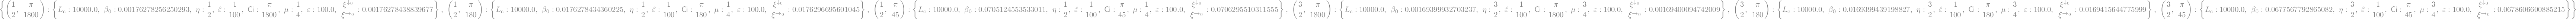

In [10]:
pr_choices

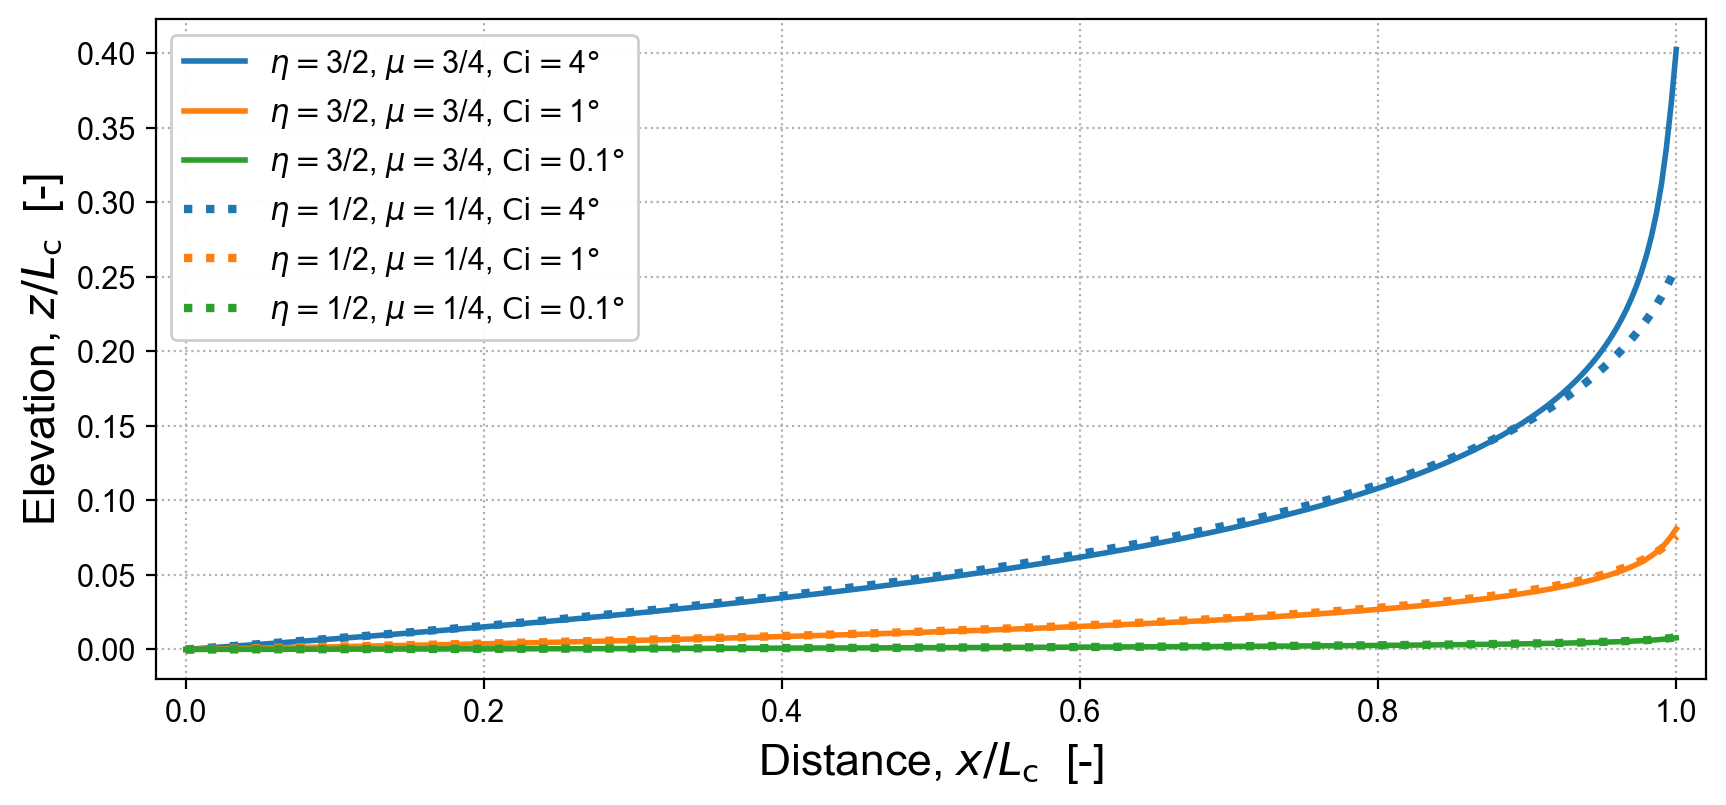

In [11]:
gr.profile_ensemble( gmes, pr_choices, job_name+'_h', fig_size=(10,7) )

# Save

Export the graphs as PNG and/or PDF image files.

In [12]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/TimeInvariantSolutions"
Exported "tis_profile_ensemble_h.png"
